In [1]:
#Mandatory imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

In [2]:
train = pd.read_json("input/train.json")
target_train=train['is_iceberg']
test = pd.read_json("input/test.json")

In [3]:
target_train=train['is_iceberg']
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
train['inc_angle']=pd.to_numeric(train['inc_angle'], errors='coerce')#We have only 133 NAs.
train['inc_angle']=train['inc_angle'].fillna(method='pad')
X_angle=train['inc_angle']
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
X_test_angle=test['inc_angle']

In [4]:
#Generate the training data
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_band_3=(X_band_1+X_band_2)/2
#X_band_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in train["inc_angle"]])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis]
                          , X_band_2[:, :, :, np.newaxis]
                         , X_band_3[:, :, :, np.newaxis]], axis=-1)

In [5]:
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_band_test_3=(X_band_test_1+X_band_test_2)/2
#X_band_test_3=np.array([np.full((75, 75), angel).astype(np.float32) for angel in test["inc_angle"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , X_band_test_3[:, :, :, np.newaxis]], axis=-1)

In [6]:
#Import Keras.
from matplotlib import pyplot
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.optimizers import rmsprop
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

from keras.datasets import cifar10
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg19 import VGG19
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

Using TensorFlow backend.


In [7]:
#Data Aug for multi-input
batch_size=64
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.,
                         height_shift_range = 0.,
                         channel_shift_range=0,
                         zoom_range = 0.2,
                         rotation_range = 10)

In [8]:
# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1,y,  batch_size=batch_size,seed=55)
    genX2 = gen.flow(X1,X2, batch_size=batch_size,seed=55)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[1]], X1i[1]

In [9]:
# Finally create generator
def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=10, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

In [10]:
def getVggAngleModel():
    input_2 = Input(shape=[1], name="angle")
    angle_layer = Dense(1, )(input_2)
    base_model = VGG16(weights='imagenet', include_top=False, 
                 input_shape=X_train.shape[1:], classes=1)
    x = base_model.get_layer('block5_pool').output
    

    x = GlobalMaxPooling2D()(x)
    merge_one = concatenate([x, angle_layer])
    merge_one = Dense(512, activation='relu', name='fc2')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    merge_one = Dense(512, activation='relu', name='fc3')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    
    predictions = Dense(1, activation='sigmoid')(merge_one)
    
    model = Model(inputs=[base_model.input, input_2], outputs=predictions)
    
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model

In [11]:
#def myAngleCV(X_train, X_angle, X_test):
K=5
folds = list(StratifiedKFold(n_splits=K, shuffle=True, random_state=16).split(X_train, target_train))
y_test_pred_log = 0
y_train_pred_log=0
y_valid_pred_log = 0.0*target_train
for j, (train_idx, test_idx) in enumerate(folds):
    print('\n===================FOLD=',j)
    X_train_cv = X_train[train_idx]
    y_train_cv = target_train[train_idx]
    X_holdout = X_train[test_idx]
    Y_holdout= target_train[test_idx]
    
    #Angle
    X_angle_cv=X_angle[train_idx]
    X_angle_hold=X_angle[test_idx]
    #define file path and get callbacks
    file_path = "%s_aug_model_weights.hdf5"%j
    callbacks = get_callbacks(filepath=file_path, patience=5)
    gen_flow = gen_flow_for_two_inputs(X_train_cv, X_angle_cv, y_train_cv)
    galaxyModel= getVggAngleModel()
    histr = galaxyModel.fit_generator(
            gen_flow,
            steps_per_epoch=24,
            epochs=100,
            shuffle=True,
            verbose=1,
            validation_data=([X_holdout,X_angle_hold], Y_holdout),
            callbacks=callbacks)
     #Getting the Best Model
    galaxyModel.load_weights(filepath=file_path)
    #Getting Training Score
    score = galaxyModel.evaluate([X_train_cv,X_angle_cv], y_train_cv, verbose=0)
    print('Train loss:', score[0])
    print('Train accuracy:', score[1])
    #Getting Test Score
    score = galaxyModel.evaluate([X_holdout,X_angle_hold], Y_holdout, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    #Getting validation Score.
    pred_valid=galaxyModel.predict([X_holdout,X_angle_hold])
    y_valid_pred_log[test_idx] = pred_valid.reshape(pred_valid.shape[0])

    #Getting Test Scores
    temp_test=galaxyModel.predict([X_test, X_test_angle])
    y_test_pred_log+=temp_test.reshape(temp_test.shape[0])

    #Getting Train Scores
    temp_train=galaxyModel.predict([X_train, X_angle])
    y_train_pred_log+=temp_train.reshape(temp_train.shape[0])

y_test_pred_log=y_test_pred_log/K
y_train_pred_log=y_train_pred_log/K

print('\n Train Log Loss Validation= ',log_loss(target_train, y_train_pred_log))
print(' Test Log Loss Validation= ',log_loss(target_train, y_valid_pred_log))
#return y_test_pred_log


===================FOLD= 0
Epoch 1/100
24/24 [==============================] - 16s 663ms/step - loss: 0.7202 - acc: 0.6322 - val_loss: 0.4321 - val_acc: 0.8043
Epoch 2/100
24/24 [==============================] - 12s 489ms/step - loss: 0.5822 - acc: 0.6776 - val_loss: 0.6571 - val_acc: 0.6304
Epoch 3/100
24/24 [==============================] - 12s 490ms/step - loss: 0.7486 - acc: 0.5587 - val_loss: 0.7268 - val_acc: 0.4689
Epoch 4/100
24/24 [==============================] - 12s 491ms/step - loss: 0.7370 - acc: 0.5021 - val_loss: 0.6890 - val_acc: 0.6211
Epoch 5/100
24/24 [==============================] - 12s 491ms/step - loss: 0.7383 - acc: 0.5104 - val_loss: 0.6575 - val_acc: 0.6894
Epoch 6/100
24/24 [==============================] - 12s 494ms/step - loss: 0.6190 - acc: 0.6557 - val_loss: 0.4968 - val_acc: 0.7671
Epoch 7/100
24/24 [==============================] - 13s 544ms/step - loss: 0.4951 - acc: 0.7417 - val_loss: 0.3572 - val_acc: 0.8385
Epoch 8/100
24/24 [===============

24/24 [==============================] - 12s 502ms/step - loss: 0.1943 - acc: 0.9198 - val_loss: 0.1994 - val_acc: 0.9221
Epoch 25/100
24/24 [==============================] - 12s 501ms/step - loss: 0.2232 - acc: 0.8999 - val_loss: 0.2026 - val_acc: 0.9003
Epoch 26/100
24/24 [==============================] - 13s 522ms/step - loss: 0.2502 - acc: 0.8901 - val_loss: 0.1909 - val_acc: 0.9097
Epoch 27/100
24/24 [==============================] - 12s 500ms/step - loss: 0.2636 - acc: 0.8895 - val_loss: 0.2112 - val_acc: 0.9097
Epoch 28/100
24/24 [==============================] - 12s 512ms/step - loss: 0.1937 - acc: 0.9125 - val_loss: 0.1963 - val_acc: 0.9190
Epoch 29/100
24/24 [==============================] - 12s 500ms/step - loss: 0.1716 - acc: 0.9309 - val_loss: 0.2017 - val_acc: 0.9190
Epoch 30/100
24/24 [==============================] - 12s 501ms/step - loss: 0.1795 - acc: 0.9169 - val_loss: 0.2141 - val_acc: 0.9128
Epoch 31/100
24/24 [==============================] - 12s 500ms/step

Epoch 27/100
24/24 [==============================] - 12s 501ms/step - loss: 0.1896 - acc: 0.9267 - val_loss: 0.2484 - val_acc: 0.8781
Epoch 28/100
24/24 [==============================] - 13s 526ms/step - loss: 0.1422 - acc: 0.9458 - val_loss: 0.2340 - val_acc: 0.8844
Epoch 29/100
24/24 [==============================] - 12s 500ms/step - loss: 0.1581 - acc: 0.9381 - val_loss: 0.2497 - val_acc: 0.8969
Epoch 30/100
24/24 [==============================] - 12s 501ms/step - loss: 0.1744 - acc: 0.9319 - val_loss: 0.2496 - val_acc: 0.9000
Epoch 31/100
24/24 [==============================] - 12s 502ms/step - loss: 0.1485 - acc: 0.9439 - val_loss: 0.2476 - val_acc: 0.8844
Epoch 32/100
24/24 [==============================] - 13s 525ms/step - loss: 0.1483 - acc: 0.9400 - val_loss: 0.2295 - val_acc: 0.9062
Epoch 33/100
24/24 [==============================] - 13s 521ms/step - loss: 0.1470 - acc: 0.9472 - val_loss: 0.2232 - val_acc: 0.9000
Epoch 34/100
24/24 [==============================] - 1

https://www.kaggle.com/fabsta/getvgganglemodel-mobilenet-lb-0-1626

In [12]:
#preds=myAngleCV(X_train, X_angle, X_test)
preds = y_test_pred_log

In [13]:
# Submission to kaggle
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=preds
submission.to_csv('sub_03.csv', index=False)

dict_keys(['val_acc', 'acc', 'val_loss', 'loss'])


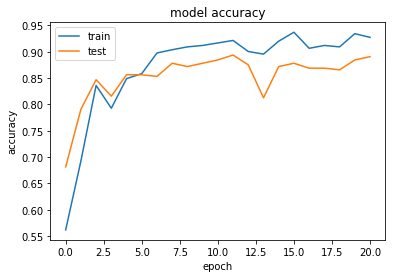

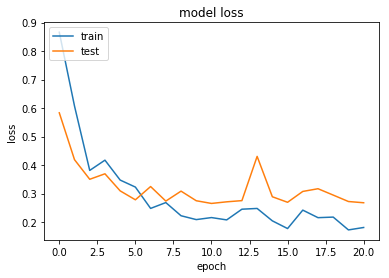

In [14]:
# list all data in history
print(histr.history.keys())
# summarize history for accuracy
plt.plot(histr.history['acc'])
plt.plot(histr.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(histr.history['loss'])
plt.plot(histr.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()